/home/ardie85/PHD/Research/code/.venv/lib/python3.10/site-packages/gym/wrappers/monitoring/video_recorder.py:9: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  import distutils.spawn


Using device: cuda


/tmp/ipykernel_10542/2285026080.py:70: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  states = torch.FloatTensor(states).to(self.device)


rewards: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Episode: 1, Total Reward: 13.0, Average Reward: 13.0
rewards: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Episode: 2, Total Reward: 45.0, Average Reward: 29.0
rewards: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Episode: 3, Total Reward: 10.0, Average Reward: 22.666666666666668
rewards: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Episode: 4, Total Reward: 30.0, Average Reward: 24.5
rewards: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Episode: 5, Total Reward: 11.0, Average Reward: 21.8
rewards: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Episode: 6, Total Reward: 10.0, Average Reward: 19.833333333333332

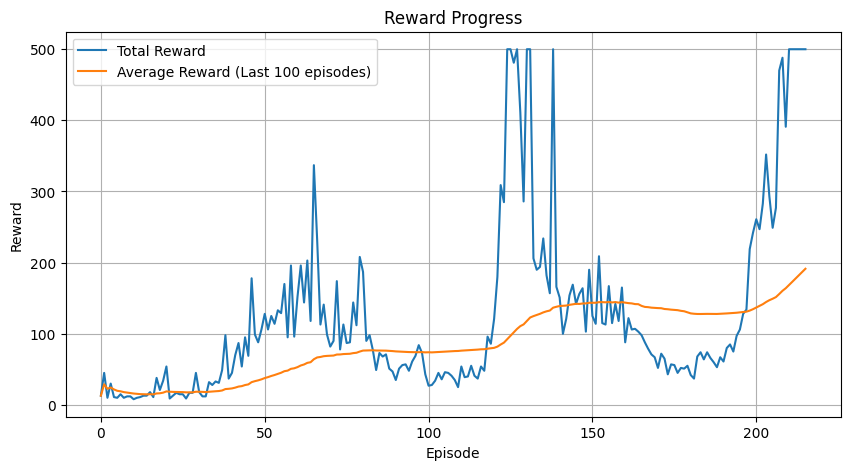

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt

class ActorCritic(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_size=64):
        super(ActorCritic, self).__init__()
        self.actor = nn.Sequential(
            nn.Linear(input_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_dim)
        )
        self.critic = nn.Sequential(
            nn.Linear(input_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, x):
        return self.actor(x), self.critic(x)

class PPOAgent:
    def __init__(self, env, gamma=0.99, epsilon=0.2, lr=0.001, clip_grad=0.5, device='cuda'):
        self.env = env
        self.device = device
        self.state_dim = env.observation_space.shape[0]
        if isinstance(env.action_space, gym.spaces.Discrete):
            self.action_dim = env.action_space.n  # Discrete action space
        elif isinstance(env.action_space, gym.spaces.Box):
            self.action_dim = env.action_space.shape[0]  # Continuous action space
        self.gamma = gamma
        self.epsilon = epsilon
        self.clip_grad = clip_grad

        self.policy_net = ActorCritic(self.state_dim, self.action_dim).to(device)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
        self.total_rewards = []
        self.avg_rewards = []

    def get_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        action_logits, _ = self.policy_net(state)
        if isinstance(self.env.action_space, gym.spaces.Discrete):
            action_probs = torch.softmax(action_logits, dim=-1)
            action_dist = torch.distributions.Categorical(action_probs)
            action = action_dist.sample()
        elif isinstance(self.env.action_space, gym.spaces.Box):
            action_dist = torch.distributions.Normal(action_logits, torch.tensor(0.1))  # Standard deviation for exploration
            action = action_dist.sample()
        return action.detach().cpu().numpy()[0]

    def compute_advantages(self, rewards, dones, values):
        advantages = np.zeros_like(rewards, dtype=np.float32)
        next_value = 0 if dones[-1] else self.policy_net(torch.FloatTensor(self.env.reset()).unsqueeze(0).to(self.device))[1].detach().cpu().numpy()[0][0]
        for t in reversed(range(len(rewards))):
            next_value = rewards[t] + self.gamma * next_value * (1 - dones[t])
            advantages[t] = next_value - values[t]
            next_value = values[t]
        return advantages

    def train(self, states, actions, old_probs, advantages, returns):
        states = torch.FloatTensor(states).to(self.device)
        actions = torch.FloatTensor(actions).to(self.device)
        old_probs = torch.FloatTensor(old_probs).to(self.device)
        advantages = torch.FloatTensor(advantages).to(self.device)
        returns = torch.FloatTensor(returns).to(self.device)

        for _ in range(10):  # PPO epoch
            action_probs, values = self.policy_net(states)
            if isinstance(self.env.action_space, gym.spaces.Discrete):
                action_probs = torch.softmax(action_probs, dim=-1)
                action_dist = torch.distributions.Categorical(action_probs)
                entropy = action_dist.entropy().mean()
                action_log_probs = action_dist.log_prob(actions.squeeze(-1))
            elif isinstance(self.env.action_space, gym.spaces.Box):
                action_dist = torch.distributions.Normal(action_probs, torch.tensor(0.1))
                entropy = action_dist.entropy().mean().sum()
                action_log_probs = action_dist.log_prob(actions).sum(dim=-1)

            ratio = torch.exp(action_log_probs - old_probs)
            clipped_ratio = torch.clamp(ratio, 1 - self.epsilon, 1 + self.epsilon)
            actor_loss = -torch.min(ratio * advantages, clipped_ratio * advantages).mean()
            critic_loss = nn.MSELoss()(values.squeeze(-1), returns)

            loss = actor_loss + 0.5 * critic_loss - 0.01 * entropy  # Entropy bonus

            self.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), self.clip_grad)
            self.optimizer.step()

    def train_on_episode(self, num_episodes):
        recent_rewards = deque(maxlen=100)
        success = False
        for episode in range(num_episodes):
            states, actions, rewards, dones, values, old_probs = [], [], [], [], [], []
            state = self.env.reset()
            done = False

            while not done:
                action = self.get_action(state)
                value = self.policy_net(torch.FloatTensor(state).unsqueeze(0).to(self.device))[1].detach().cpu().numpy()[0][0]
                next_state, reward, done, _ = self.env.step(action)

                states.append(state)
                actions.append(action)
                rewards.append(reward)
                dones.append(done)
                values.append(value)

                action_probs = self.policy_net(torch.FloatTensor(state).unsqueeze(0).to(self.device))[0].detach().cpu().numpy()[0]
                old_probs.append(action_probs[action])

                state = next_state

            advantages = self.compute_advantages(rewards, dones, values)
            returns = advantages + np.array(values)

            self.train(states, actions, old_probs, advantages, returns)

            print(f"rewards: {rewards}")

            total_reward = sum(rewards)
            recent_rewards.append(total_reward)
            avg_reward = np.mean(recent_rewards)

            print(f"Episode: {episode + 1}, Total Reward: {total_reward}, Average Reward: {avg_reward}")

            if avg_reward > 195:
                print(f"Problem solved after {episode + 1} episodes.")
                success = True
                break

            self.total_rewards.append(total_reward)
            self.avg_rewards.append(avg_reward)

        if not success:
            print("Failed to solve the problem.")

        # Plotting after all episodes are completed
        plt.figure(figsize=(10, 5))
        plt.plot(self.total_rewards, label='Total Reward')
        plt.plot(self.avg_rewards, label='Average Reward (Last 100 episodes)')
        plt.title('Reward Progress')
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        plt.legend()
        plt.grid(True)
        plt.show()

if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    env = gym.make('CartPole-v1')
    agent = PPOAgent(env, device=device)
    agent.train_on_episode(1000)
